In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from imblearn.over_sampling import RandomOverSampler


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv
/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv
/kaggle/input/equity-post-HCT-survival-predictions/train.csv
/kaggle/input/equity-post-HCT-survival-predictions/test.csv


In [2]:
# Load and preview the data dictionary
data_dictionary = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv')

# Display the first few rows of the data dictionary
data_dictionary.head()


,variable,description,type,values
0,dri_score,Refined disease risk index,Categorical,['Intermediate' 'High' 'N/A - non-malignant in...
1,psych_disturb,Psychiatric disturbance,Categorical,['Yes' 'No' nan 'Not done']
2,cyto_score,Cytogenetic score,Categorical,['Intermediate' 'Favorable' 'Poor' 'TBD' nan '...
3,diabetes,Diabetes,Categorical,['No' 'Yes' nan 'Not done']
4,hla_match_c_high,Recipient / 1st donor allele level (high resol...,Numerical,NaN


In [3]:
# Load and preview the training data
train_data = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
train_data.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [5]:
# Calculate missing values for each column
missing_values = train_data.isnull().sum()
missing_percentage = (missing_values / len(train_data)) * 100

# Combine into a DataFrame for better readability
missing_data_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage Missing': missing_percentage
}).sort_values(by='Percentage Missing', ascending=False)

# Display columns with significant missing values
missing_data_summary[missing_data_summary['Percentage Missing'] > 30]


,Missing Values,Percentage Missing
tce_match,18996,65.958333
mrd_hct,16597,57.628472
cyto_score_detail,11923,41.399306
tce_div_match,11396,39.569444
tce_imm_match,11133,38.656250


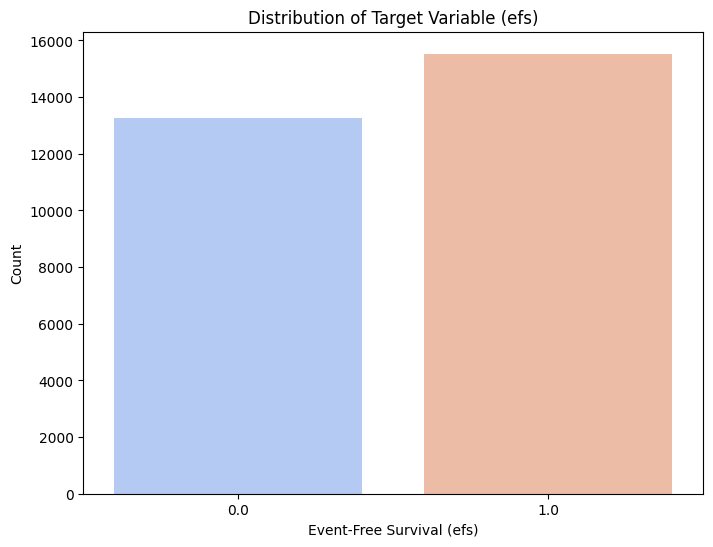

In [6]:
# Plot 1: Target Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='efs', data=train_data, palette='coolwarm')
plt.title('Distribution of Target Variable (efs)')
plt.xlabel('Event-Free Survival (efs)')
plt.ylabel('Count')
plt.show()

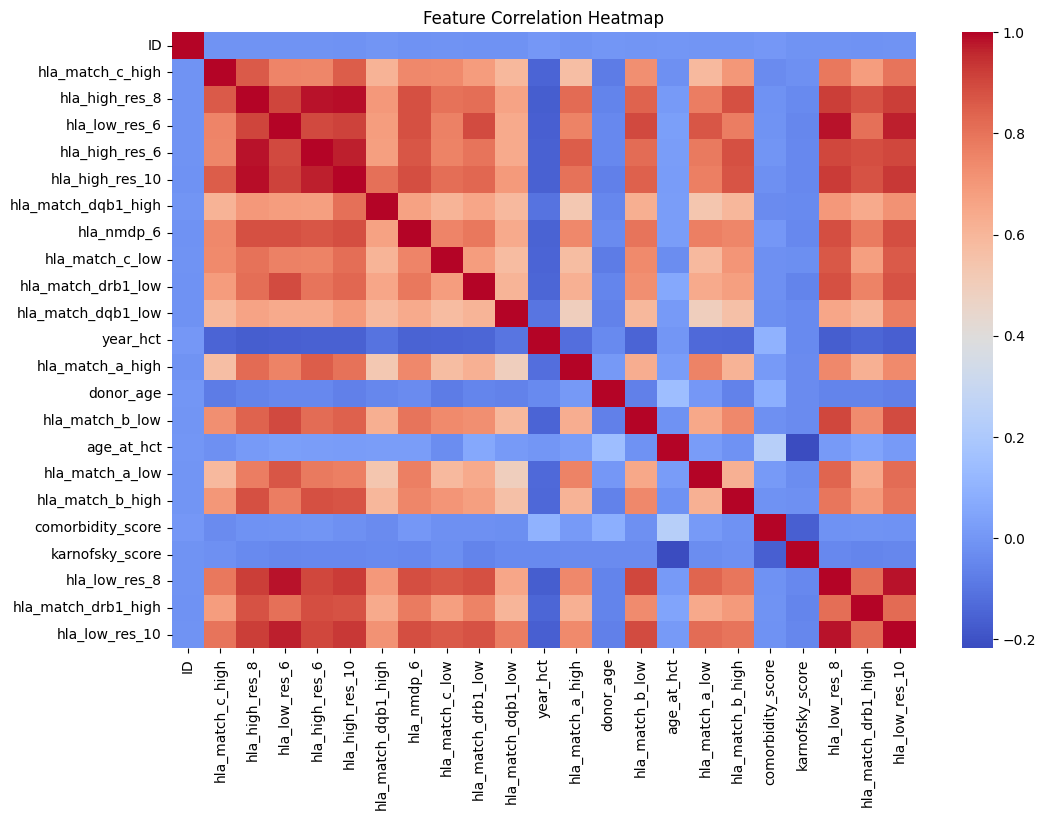

In [7]:
# Define numerical columns
numerical_cols = train_data.select_dtypes(include=['float64', 'int64']).columns

# Exclude target variables
numerical_cols_corr = numerical_cols.drop(['efs', 'efs_time'])

# Calculate correlation matrix
corr_matrix = train_data[numerical_cols_corr].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


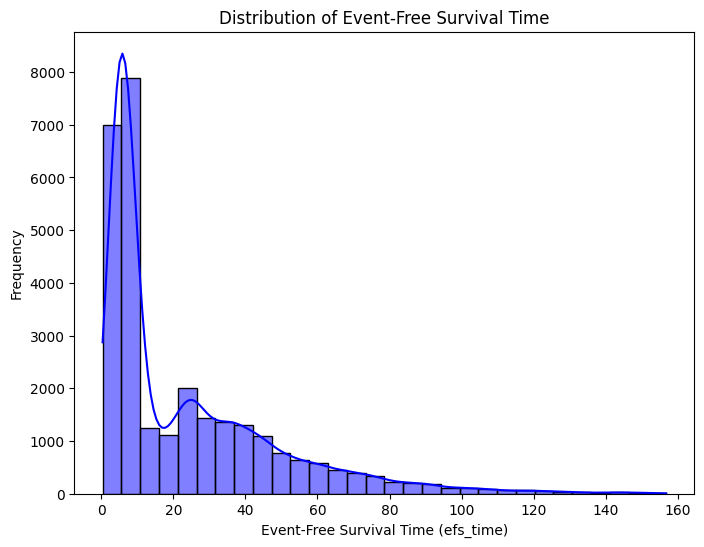

In [8]:
plt.figure(figsize=(8, 6))
sns.histplot(train_data['efs_time'], bins=30, kde=True, color='blue')
plt.title('Distribution of Event-Free Survival Time')
plt.xlabel('Event-Free Survival Time (efs_time)')
plt.ylabel('Frequency')
plt.show()

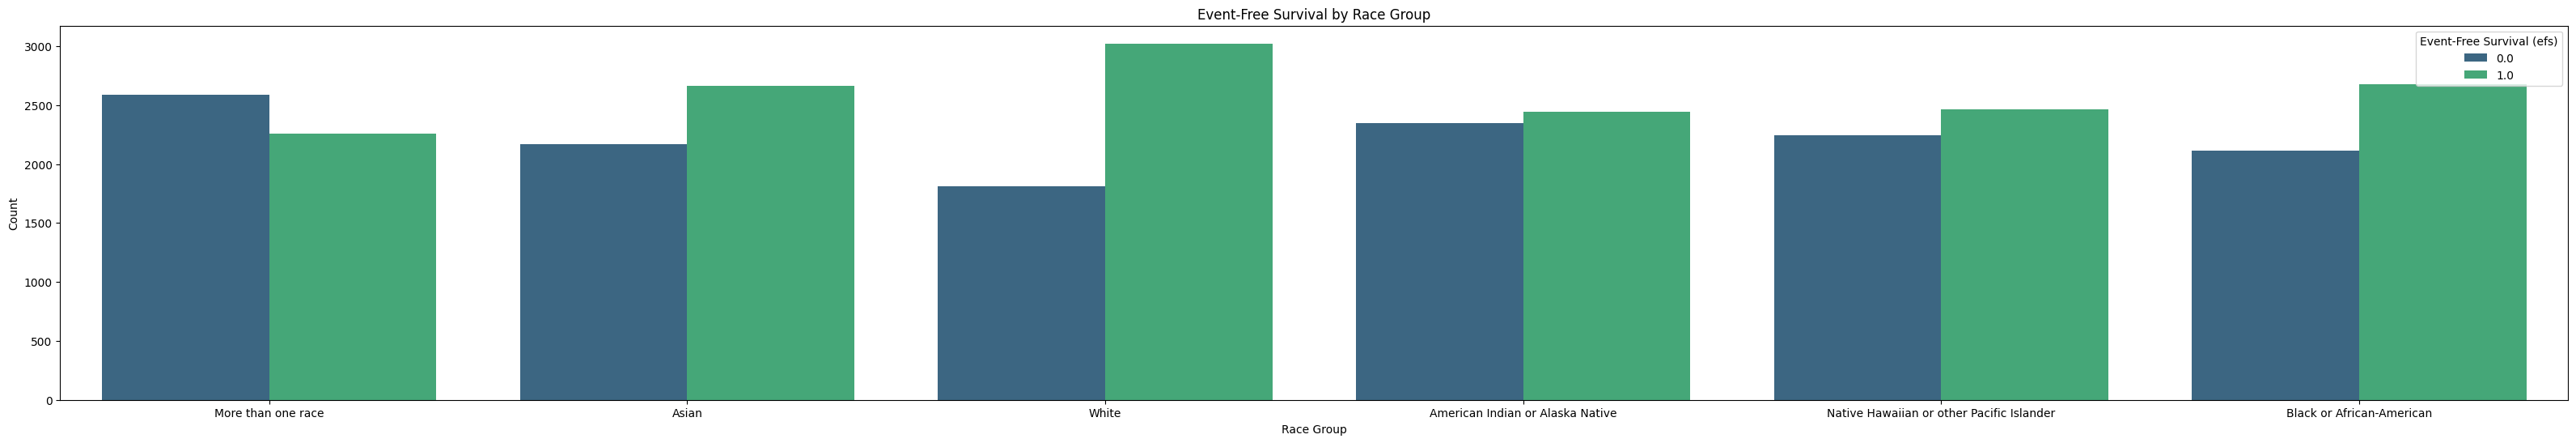

In [9]:
# Plot 4: Categorical Feature Analysis (Example: race_group)
if 'race_group' in train_data.columns:
    plt.figure(figsize=(40, 6))
    sns.countplot(x='race_group', hue='efs', data=train_data, palette='viridis')
    plt.title('Event-Free Survival by Race Group')
    plt.xlabel('Race Group')
    plt.ylabel('Count')
    plt.legend(title='Event-Free Survival (efs)', loc='upper right')
    plt.show()

In [10]:
# Drop columns with more than 30% missing values
threshold = 30  # percentage
cols_to_drop = missing_data_summary[missing_data_summary['Percentage Missing'] > threshold].index
train_data_cleaned = train_data.drop(columns=cols_to_drop)

# Impute missing values for remaining columns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# Separate numerical and categorical columns
numerical_cols = train_data_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = train_data_cleaned.select_dtypes(include=['object']).columns

# Impute numerical columns with mean
num_imputer = IterativeImputer(max_iter=100, random_state=0)
train_data_cleaned[numerical_cols] = num_imputer.fit_transform(train_data_cleaned[numerical_cols])

# Impute categorical columns with most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
train_data_cleaned[categorical_cols] = cat_imputer.fit_transform(train_data_cleaned[categorical_cols])


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [11]:
train_data_encoded = pd.get_dummies(train_data_cleaned, columns=categorical_cols, drop_first=True)

In [12]:
scaler = MinMaxScaler()
train_data_scaled = train_data_encoded.copy()
train_data_scaled[numerical_cols] = scaler.fit_transform(train_data_encoded[numerical_cols])

In [13]:
X = train_data_scaled.drop(columns=['efs', 'efs_time'])  # Exclude target variables
y = train_data_scaled['efs']  # Binary target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

ros = RandomOverSampler(sampling_strategy='minority', 
                        random_state=0) 

In [14]:
# Convert boolean columns to integers (if any exist)
bool_cols = X_train.select_dtypes(include=['bool']).columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_val[bool_cols] = X_val[bool_cols].astype(int)

# Double-check for object columns and handle them
object_cols = X_train.select_dtypes(include=['object']).columns
if not object_cols.empty:
    print(f"Remaining non-numeric columns: {object_cols}")
    # Convert object columns (if any remain) to numeric using one-hot encoding
    X_train = pd.get_dummies(X_train, columns=object_cols, drop_first=True)
    X_val = pd.get_dummies(X_val, columns=object_cols, drop_first=True)

# Align validation data to match training data columns
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

# Verify data types before conversion to tensors
print(X_train.dtypes)
print("Data successfully converted to PyTorch tensors.")

ID                                   float64
hla_match_c_high                     float64
hla_high_res_8                       float64
hla_low_res_6                        float64
hla_high_res_6                       float64
                                      ...   
melphalan_dose_N/A, Mel not given      int64
cardiac_Not done                       int64
cardiac_Yes                            int64
pulm_moderate_Not done                 int64
pulm_moderate_Yes                      int64
Length: 131, dtype: object
Data successfully converted to PyTorch tensors.


In [15]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

In [16]:
class SurvivalPredictor(nn.Module):
    def __init__(self, input_size):
        super(SurvivalPredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.fc(x)

# Initialize model, loss function, and optimizer
input_size = X_train_tensor.shape[1]
model = SurvivalPredictor(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs.squeeze(), y_val_tensor)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


Epoch 1/10, Loss: 0.7003, Val Loss: 0.6951
Epoch 2/10, Loss: 0.6956, Val Loss: 0.6919
Epoch 3/10, Loss: 0.6920, Val Loss: 0.6893
Epoch 4/10, Loss: 0.6891, Val Loss: 0.6871
Epoch 5/10, Loss: 0.6866, Val Loss: 0.6850
Epoch 6/10, Loss: 0.6843, Val Loss: 0.6831
Epoch 7/10, Loss: 0.6821, Val Loss: 0.6812
Epoch 8/10, Loss: 0.6799, Val Loss: 0.6792
Epoch 9/10, Loss: 0.6777, Val Loss: 0.6770
Epoch 10/10, Loss: 0.6754, Val Loss: 0.6747


In [17]:
# Define lists to store losses
losses = []
val_losses = []

# Training Loop
for epoch in range(epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    y_train_pred = model(X_train_tensor).squeeze()
    train_loss = criterion(y_train_pred, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_tensor).squeeze()
        val_loss = criterion(y_val_pred, y_val_tensor)

    # Record losses
    losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    # Print epoch details (optional)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


Epoch 1/10, Training Loss: 0.6728, Validation Loss: 0.6721
Epoch 10/10, Training Loss: 0.6420, Validation Loss: 0.6410


In [18]:
with torch.no_grad():
    y_val_pred = model(X_val_tensor).squeeze()
    auc = roc_auc_score(y_val_tensor, y_val_pred)

print(f"Validation AUC: {auc:.4f}")

Validation AUC: 0.6979


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

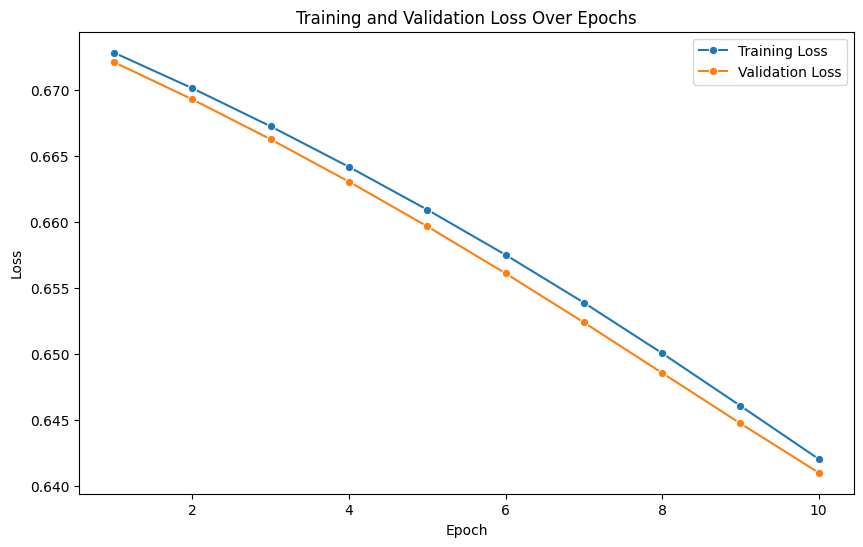

In [19]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, epochs + 1), y=losses, label='Training Loss', marker='o')
sns.lineplot(x=range(1, epochs + 1), y=val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [20]:
# Define the dataset path
dataset_dir = '/kaggle/input/equity-post-HCT-survival-predictions/'

# Load the test dataset
test_data_path = os.path.join(dataset_dir, 'test.csv')
test_data = pd.read_csv(test_data_path)

# Create a DataFrame for the submission
submission = pd.DataFrame({
    'ID': test_data['ID'],  # Replace with the actual ID column name in the test data
    'prediction': 0.5  # Default predictions (to be updated later)
})

# Save the submission file
submission.to_csv('submission.csv', index=False)
print("Sample submission file created.")
print(submission)


Sample submission file created.
      ID  prediction
0  28800         0.5
1  28801         0.5
2  28802         0.5
